# Analysis of Review Time vs Retention and Rating

This notebook explores how real review durations (ms) correlate with FSRS-estimated retrievability and the ratings provided by the user.

In [1]:
import os
import sys
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from statsmodels.miscmodels.ordinal_model import OrderedModel
from tqdm.auto import tqdm

# Add src to path
sys.path.append(os.path.abspath("../src"))

import fsrs_engine
from anki_utils import (
    START_DATE,
    get_review_history_stats,
    infer_review_weights,
    load_anki_history,
)
from simulate_fsrs import RustOptimizer, _load_initial_state, run_simulation
from simulation_config import SeededData, SimulationConfig

/home/acbraith/projects/fsrs_experiments/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
# Shared configuration
N_DAYS = int(os.getenv("N_DAYS", "330"))
SEED_HISTORY = os.getenv("ANKI_COLLECTION", "../collection.anki2")
DECK_CONFIG = os.getenv("DECK_CONFIG", "ChineseReading")

if SEED_HISTORY and not os.path.exists(SEED_HISTORY):
    SEED_HISTORY = None

## Data Loading and FSRS Fitting

In [3]:
print(f"Loading history for {DECK_CONFIG}...")
logs_data, last_rev = load_anki_history(SEED_HISTORY, deck_config_name=DECK_CONFIG)

all_days = (
    (logs_data.review_timestamps - np.datetime64(START_DATE)) / np.timedelta64(1, "D")
).astype(np.int32)

print(f"Fitting FSRS-6 parameters on {len(logs_data.ratings)} reviews...")
optimizer = RustOptimizer(logs_data.card_ids, logs_data.ratings, all_days)
fitted_params = tuple(optimizer.compute_optimal_parameters())
print(f"Fitted params: {fitted_params}")

# Pre-calculate card states for seeding
print("Pre-calculating initial card states (replaying history)...")
deck_t, deck_s, logs_data, current_date = _load_initial_state(
    fitted_params, fitted_params, None, SEED_HISTORY, DECK_CONFIG, None
)
seeded_data = SeededData(
    logs=logs_data,
    last_rev=current_date - timedelta(days=1),
    true_cards=deck_t,
    sys_cards=deck_s,
)
print("Seeding complete.")

Loading history for ChineseReading...
Anki database version 18 detected.
Querying reviews for 1 matching decks...


Successfully loaded 152534 reviews for 13641 cards.
Fitting FSRS-6 parameters on 152534 reviews...
Fitted params: (0.008048166520893574, 1.3396419286727905, 14.097423553466797, 15.40642261505127, 6.413300037384033, 0.8334000110626221, 3.019399881362915, 0.0010000000474974513, 1.8722000122070312, 0.16660000383853912, 0.7960000038146973, 1.4835000038146973, 0.061400000005960464, 0.2628999948501587, 1.648300051689148, 0.6014000177383423, 1.8729000091552734, 0.5425000190734863, 0.09120000153779984, 0.0658000037074089, 0.1542000025510788)
Pre-calculating initial card states (replaying history)...
Anki database version 18 detected.
Querying reviews for 1 matching decks...
Successfully loaded 152534 reviews for 13641 cards.
Seeding complete.


In [4]:
stats = get_review_history_stats(logs_data, fitted_params)
df = pd.DataFrame(stats)
df = df.dropna(subset=["duration"])
# Convert duration from ms to seconds for easier reading
df["duration_sec"] = df["duration"] / 1000.0
df["is_new_card"] = df["stability"] == 0
mean_duration_sec = df["duration_sec"].mean()
df.head()

,card_id,retention,rating,duration,stability,difficulty,elapsed_days,duration_sec,is_new_card
0,1393817670651,0.519463,4,4539.0,0.000000,3.259772,0.000000,4.539,True
1,1393817670651,0.966267,4,4309.0,15.406423,1.000000,3.916837,4.309,False
2,1393817670651,0.959095,4,5875.0,47.783492,1.000000,15.162529,5.875,False
3,1393817670651,0.959702,4,5133.0,148.916333,1.000000,46.437872,5.133,False
4,1393817670651,0.948091,3,2822.0,405.784699,1.000000,170.931361,2.822,False


In [5]:
from anki_utils import (
    calculate_expected_d0,
)

# Baseline features for new cards (matches get_review_history_stats)
weights = infer_review_weights(logs_data)
w_first = weights.first
prob_first_success = 1.0 - w_first[0]
expected_d0 = calculate_expected_d0(w_first, fitted_params)

## Review Time Estimation
Review time is not constant; it can be more expensive to review certain types of cards.

We fit a linear model to give us more accurate estimates of review time. This will use the card state and FSRS model output (i.e. new/review, stability, difficulty and retention) alongside the rating given to estimate review time.

We use cross-validation and an L1 penalty term to check if any features are not useful for generalisably forecasting review time.

Optimal Alpha: 0.067011
R-squared: 0.0326
--- Coefficients ---
is_new_card: 0.0112
retention: -0.3087
rating: -0.4970
stability: -0.6700
difficulty: -0.2657


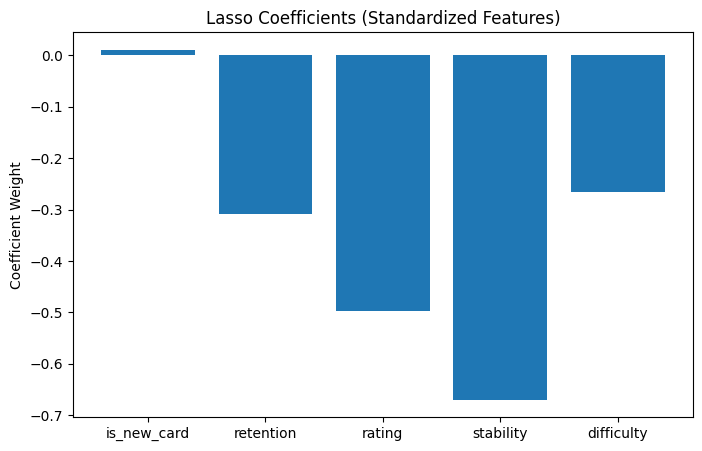

In [6]:
# Prepare features and target
features = ["is_new_card", "retention", "rating", "stability", "difficulty"]
target = "duration_sec"
features_matrix = df[features].values
target_values = df[target].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_matrix)

# Fit Lasso with Cross-Validation to select alpha
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, target_values)

print(f"Optimal Alpha: {lasso.alpha_:.6f}")
print(f"R-squared: {lasso.score(X_scaled, target_values):.4f}")
print("--- Coefficients ---")
for feat, coef in zip(features, lasso.coef_, strict=False):
    print(f"{feat}: {coef:.4f}")

plt.figure(figsize=(8, 5))
plt.bar(features, lasso.coef_)
plt.title("Lasso Coefficients (Standardized Features)")
plt.ylabel("Coefficient Weight")
plt.show()

### Statistical Significance of Review Time Factors
While the Lasso model above shows the weight of each factor, we can use Ordinary Least Squares (OLS) to determine the "statistical significance" (p-values). 

**For non-experts:** A p-value (P>|t|) less than 0.05 indicates that we are 95% confident the factor has a real effect on review time and isn't just random noise.

In [7]:
# Add a constant (intercept) to the features
X_ols = sm.add_constant(X_scaled)
ols_time = sm.OLS(target_values, X_ols).fit()

print(ols_time.summary(xname=["const"] + features))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1048.
Date:                Wed, 04 Feb 2026   Prob (F-statistic):               0.00
Time:                        20:40:10   Log-Likelihood:            -4.9125e+05
No. Observations:              152534   AIC:                         9.825e+05
Df Residuals:                  152528   BIC:                         9.826e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.9024      0.016    315.966      

#### Visualizing the Size of Impact
To make this intuitive, let's look at how much the predicted review time changes for different types of reviews compared to the **Constant Baseline** (the average of all reviews).

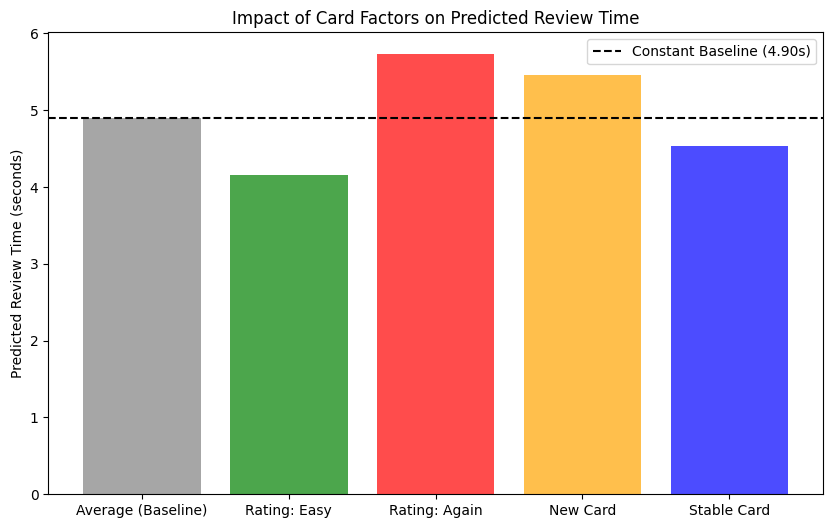

An 'Easy' review is predicted to take 4.15s, while an 'Again' review takes 5.73s.


In [8]:
mean_series = df[features].mean()


def create_scenario(**kwargs):
    s = mean_series.copy()
    for k, v in kwargs.items():
        s[k] = v
    return s.values


scenarios = {
    "Average (Baseline)": mean_series.values,
    "Rating: Easy": create_scenario(rating=4),
    "Rating: Again": create_scenario(rating=1),
    "New Card": create_scenario(is_new_card=1, stability=0, difficulty=expected_d0),
    "Stable Card": create_scenario(stability=df["stability"].quantile(0.9)),
}

scenario_names = list(scenarios.keys())
scenario_feat_vals = np.array(list(scenarios.values()))
scenario_feat_scaled = scaler.transform(scenario_feat_vals)
predictions = lasso.predict(scenario_feat_scaled)

plt.figure(figsize=(10, 6))
colors = ["gray", "green", "red", "orange", "blue"]
plt.bar(scenario_names, predictions, color=colors, alpha=0.7)
plt.axhline(
    mean_duration_sec,
    color="black",
    linestyle="--",
    label=f"Constant Baseline ({mean_duration_sec:.2f}s)",
)

plt.ylabel("Predicted Review Time (seconds)")
plt.title("Impact of Card Factors on Predicted Review Time")
plt.legend()
plt.show()

print(
    f"An 'Easy' review is predicted to take {predictions[1]:.2f}s, "
    f"while an 'Again' review takes {predictions[2]:.2f}s."
)

## Grade Prediction Model

The FSRS model estimates success/failure of a review. However, success can have various "degrees" (i.e. rating hard, good, easy). Current simulations assume this distribution is uniform across all review cards regardless of card specifics.

That is not true. We use an `OrderedModel` to determine the probability distribution over rating (Hard, Good, Easy) for a given review given that a review was successful (retrieved).

At simulation time we can sample from the distrubiton given by this `OrderedModel` rather than assuming the same probability distrubiton for all reviews.

In [9]:
# Filter for successful reviews (Rating > 1)
df_success = df[df["rating"] > 1].copy()

# OrderedModel needs at least 2 unique categories and enough data
if len(df_success) >= 10 and df_success["rating"].nunique() > 1:
    # Features for grade prediction
    grade_features = ["is_new_card", "retention", "stability", "difficulty"]
    X_grade = df_success[grade_features].values
    y_grade = df_success["rating"].values

    # Standardize features
    scaler_grade = StandardScaler()
    X_grade_scaled = scaler_grade.fit_transform(X_grade)

    # Fit OrderedModel
    try:
        mod_prob = OrderedModel(y_grade, X_grade_scaled, distr="probit")
        res_prob = mod_prob.fit(method="bfgs", disp=False)
        print(res_prob.summary())
        HAS_GRADE_MODEL = True
    except Exception as e:
        print(f"Failed to fit OrderedModel: {e}")
        HAS_GRADE_MODEL = False
else:
    print("Insufficient data for OrderedModel, falling back to simple weights.")
    HAS_GRADE_MODEL = False


def predict_grades_batch(features_list, weights, count):
    if HAS_GRADE_MODEL and len(features_list) > 0:
        x_features = np.array(features_list)
        x_scaled = scaler_grade.transform(x_features)
        probs_all = res_prob.predict(x_scaled)

        # Vectorized weighted random choice
        cum_probs = probs_all.cumsum(axis=1)
        r_vals = np.random.rand(len(probs_all), 1)
        choice_indices = (cum_probs < r_vals).sum(axis=1)
        choice_indices = np.minimum(choice_indices, len(res_prob.model.labels) - 1)

        return res_prob.model.labels[choice_indices].tolist()
    else:
        # Fallback to simple success weights
        return np.random.choice([2, 3, 4], size=count, p=weights.success).tolist()

                             OrderedModel Results                             
Dep. Variable:                      y   Log-Likelihood:                -73654.
Model:                   OrderedModel   AIC:                         1.473e+05
Method:            Maximum Likelihood   BIC:                         1.474e+05
Date:                Wed, 04 Feb 2026                                         
Time:                        20:40:15                                         
No. Observations:              118147                                         
Df Residuals:                  118141                                         
Df Model:                           4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0781      0.005     16.520      0.000       0.069       0.087
x2             0.1769      0.005     35.514      0.0

### Statistical Significance of Grade Distribution
The `OrderedModel` summary above shows the significance of each factor on the grade given (for successful reviews).

To visualize this, let's look at how the predicted probability of each grade (Hard, Good, Easy) changes as **Retention** increases, while keeping other factors constant.

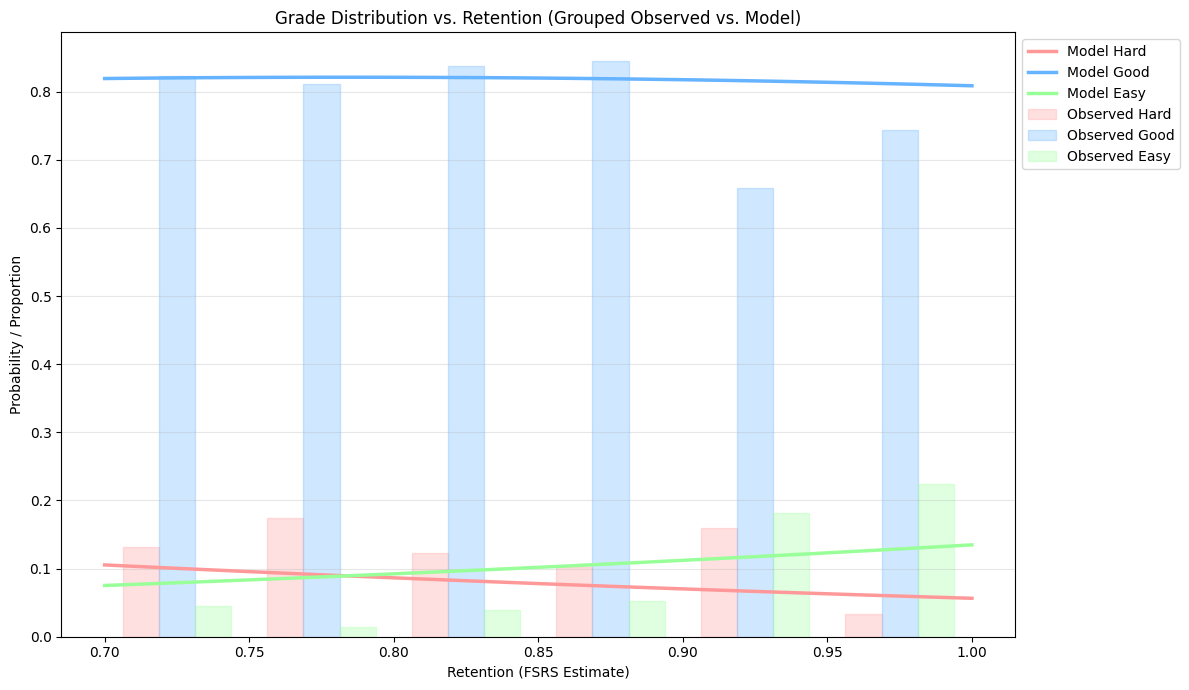

In [10]:
if HAS_GRADE_MODEL:
    # 1. Calculate Observed Proportions (Underlay)
    num_buckets = 6
    df_success["ret_bucket"] = pd.cut(
        df_success["retention"], bins=np.linspace(0.7, 1.0, num_buckets + 1)
    )
    obs_counts = (
        df_success.groupby(["ret_bucket", "rating"], observed=False)
        .size()
        .unstack(fill_value=0)
    )
    obs_props = obs_counts.div(obs_counts.sum(axis=1), axis=0)
    bin_mids = np.array([b.mid for b in obs_props.index])

    # 2. Model Prediction over range
    mean_vals = X_grade.mean(axis=0)
    ret_range = np.linspace(0.7, 1.0, 100)

    probs_list = []
    for r in ret_range:
        feat = mean_vals.copy()
        feat[1] = r
        feat_scaled = scaler_grade.transform([feat])
        probs = res_prob.predict(feat_scaled)[0]
        probs_list.append(probs)

    probs_arr = np.array(probs_list)
    labels = res_prob.model.labels  # [2, 3, 4]
    label_names = {2: "Hard", 3: "Good", 4: "Easy"}
    colors = ["#ff9999", "#66b3ff", "#99ff99"]

    plt.figure(figsize=(12, 7))
    bucket_width = (1.0 - 0.7) / num_buckets
    bar_width = bucket_width / 4
    offsets = [-bar_width, 0, bar_width]

    for i, label in enumerate(labels):
        plt.bar(
            bin_mids + offsets[i],
            obs_props[label],
            width=bar_width,
            alpha=0.3,
            color=colors[i],
            edgecolor=colors[i],
            label=f"Observed {label_names.get(label, label)}",
        )

    for i, label in enumerate(labels):
        plt.plot(
            ret_range,
            probs_arr[:, i],
            color=colors[i],
            linewidth=2.5,
            label=f"Model {label_names.get(label, label)}",
        )

    plt.xlabel("Retention (FSRS Estimate)")
    plt.ylabel("Probability / Proportion")
    plt.title("Grade Distribution vs. Retention (Grouped Observed vs. Model)")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Grade model not available for visualization.")

## Improved Optimal Retention
Current optimal retention assumes all reviews are equal. We can now estimate the true cost (in time) of a review.

Let's run simulations using these estimates for review times based on card state at time of review to see the impact this has on optimal retention.

Note these simulations are also applying the post-processing discussed in the [Optimal Retention notebook](notebooks/Optimal_Retention.ipynb).

In [11]:
def lasso_time_estimator(deck, indices, date, params, ratings):
    cur_stabs = deck.current_stabilities[indices]
    cur_last_revs = deck.current_last_reviews[indices]
    cur_diffs = deck.current_difficulties[indices]

    new_mask = np.isnat(cur_last_revs)
    rev_mask = ~new_mask

    rets = np.zeros(len(indices))
    if np.any(rev_mask):
        elapsed = (np.datetime64(date) - cur_last_revs[rev_mask]) / np.timedelta64(
            1, "D"
        )
        rets[rev_mask] = fsrs_engine.predict_retrievability(
            cur_stabs[rev_mask], elapsed, params
        )
    if np.any(new_mask):
        rets[new_mask] = prob_first_success

    feat_matrix = np.column_stack(
        [
            new_mask.astype(int),
            rets,
            ratings,
            cur_stabs,
            np.where(new_mask, expected_d0, cur_diffs),
        ]
    )

    features_scaled = scaler.transform(feat_matrix)
    pred_secs = lasso.predict(features_scaled)
    return np.maximum(0.5, pred_secs).astype(np.float32)

In [12]:
def advanced_rating_estimator(deck, indices, date, params):
    count = len(indices)
    results = np.zeros(count, dtype=np.int8)

    cur_stabs = deck.current_stabilities[indices]
    cur_last_revs = deck.current_last_reviews[indices]
    cur_diffs = deck.current_difficulties[indices]

    new_mask = np.isnat(cur_last_revs)
    rev_mask = ~new_mask

    if np.any(new_mask):
        results[new_mask] = np.random.choice(
            [1, 2, 3, 4], size=np.sum(new_mask), p=weights.first
        )

    if np.any(rev_mask):
        n_rev = np.sum(rev_mask)
        elapsed = (np.datetime64(date) - cur_last_revs[rev_mask]) / np.timedelta64(
            1, "D"
        )
        rets = fsrs_engine.predict_retrievability(cur_stabs[rev_mask], elapsed, params)
        success = np.random.random(n_rev) < rets

        results_rev = np.ones(n_rev, dtype=np.int8)
        n_success = np.sum(success)
        if n_success > 0:
            success_features = np.column_stack(
                [
                    np.zeros(n_success),
                    rets[success],
                    cur_stabs[rev_mask][success],
                    cur_diffs[rev_mask][success],
                ]
            )
            results_rev[success] = predict_grades_batch(
                success_features, weights, n_success
            )

        results[rev_mask] = results_rev

    return results

In [79]:
daily_budget_sec = 16 * 60
retentions = [
    0.1,
    0.3,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.925,
    0.95,
    0.975,
    0.99,
]


def constant_time_estimator(deck, indices, date, params, ratings):
    return np.full(len(indices), mean_duration_sec, dtype=np.float32)


results_constant = []
results_lasso = []
results_advanced = []

for ret in tqdm(retentions, desc="Simulating"):
    # 1. Constant Time Estimator
    config_const = SimulationConfig(
        n_days=N_DAYS,
        retention=str(ret),
        review_limit=None,
        new_limit=None,
        time_limit=daily_budget_sec,
        time_estimator=constant_time_estimator,
        verbose=False,
        compute_final_params=False,
        return_logs=False,
    )
    _, _, metrics_const = run_simulation(
        config_const,
        seeded_data=seeded_data,
        ground_truth=fitted_params,
        initial_params=fitted_params,
    )
    results_constant.append(metrics_const)

    # 2. Lasso Model Time Estimator (Default Rating)
    config_lasso = SimulationConfig(
        n_days=N_DAYS,
        retention=str(ret),
        review_limit=None,
        new_limit=None,
        time_limit=daily_budget_sec,
        time_estimator=lasso_time_estimator,
        verbose=False,
        compute_final_params=False,
        return_logs=False,
    )
    _, _, metrics_lasso = run_simulation(
        config_lasso,
        seeded_data=seeded_data,
        ground_truth=fitted_params,
        initial_params=fitted_params,
    )
    results_lasso.append(metrics_lasso)

    # 3. Advanced Estimator (OrderedModel Grade + Lasso Duration)
    config_adv = SimulationConfig(
        n_days=N_DAYS,
        retention=str(ret),
        review_limit=None,
        new_limit=None,
        time_limit=daily_budget_sec,
        time_estimator=lasso_time_estimator,
        rating_estimator=advanced_rating_estimator,
        verbose=False,
        compute_final_params=False,
        return_logs=False,
    )
    _, _, metrics_adv = run_simulation(
        config_adv,
        seeded_data=seeded_data,
        ground_truth=fitted_params,
        initial_params=fitted_params,
    )
    results_advanced.append(metrics_adv)

Simulating: 100%|██████████| 13/13 [00:50<00:00,  3.90s/it]


In [80]:
# 1. Determine N_max (baseline population size)
max_cards = max(
    m["card_count"] for m in results_lasso + results_constant + results_advanced
)

# 2. Baseline retention for unseen cards
r_baseline = prob_first_success


def get_adjusted_total(metrics_list, max_n, r_base):
    adjusted = []
    for m in metrics_list:
        # Current sum of retention for studied cards
        current_total = m["total_retention"]
        # Add hypothetical retention for cards we "could have" studied
        missing_cards = max_n - m["card_count"]
        # Ensure we don't subtract if a run somehow exceeded the max (unlikely)
        padding = max(0, missing_cards) * r_base
        adjusted.append(current_total + padding)
    return adjusted


adj_results_constant = get_adjusted_total(results_constant, max_cards, r_baseline)
adj_results_lasso = get_adjusted_total(results_lasso, max_cards, r_baseline)
adj_results_advanced = get_adjusted_total(results_advanced, max_cards, r_baseline)

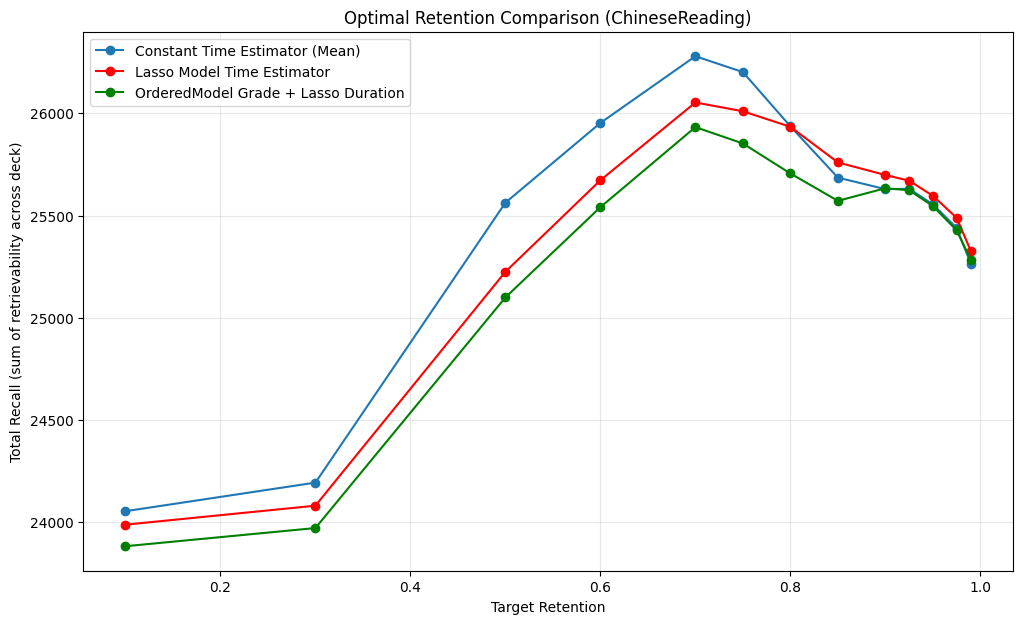

In [81]:
plt.figure(figsize=(12, 7))
plt.plot(
    retentions, adj_results_constant, marker="o", label="Constant Time Estimator (Mean)"
)
plt.plot(
    retentions,
    adj_results_lasso,
    marker="o",
    color="red",
    label="Lasso Model Time Estimator",
)
plt.plot(
    retentions,
    adj_results_advanced,
    marker="o",
    color="green",
    label="OrderedModel Grade + Lasso Duration",
)

plt.title(f"Optimal Retention Comparison ({DECK_CONFIG})")
plt.xlabel("Target Retention")
plt.ylabel("Total Recall (sum of retrievability across deck)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()